# Uncertainty Estimation

**Uncertainty Estimation** é importante para garantir a segurança e a robustez dos sistemas de IA.

Machine Learning aplicado requer o gerenciamento de incertezas.

Existem muitas fontes de incerteza em um projeto de machine learning, incluindo variação nos valores de dados específicos, a amostra de dados coletados do domínio e a natureza imperfeita de quaisquer modelos desenvolvidos a partir de tais dados.

Neste notebook, veremos um exemplo de como podemos estimar a incerteza de um modelo.

In [1]:
import torch
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

Os dados vão vir de uma distribuição conhecida, de forma que possamos checar a resposta:

In [2]:
def generate_batch(batch_size=32):
    x = np.random.random(batch_size) * 10 - 5
    sd = 0.05 + 0.1 * (x + 5)
    y = np.cos(x) - 0.3 * x + np.random.randn(batch_size) * sd
    return x, y

Visualizamos os dados:

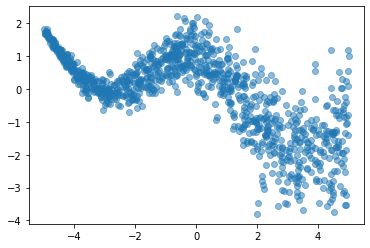

In [3]:
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5);

Criamos o modelo:

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.ann1 = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )
        self.ann2 = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )
    
    def forward(self, inputs):
        return self.ann1(inputs), self.ann2(inputs)

Instanciamos o modelo:

In [5]:
model = Model()

Criamos uma função Loss customizada:

In [6]:
def criterion(outputs, targets):
    mu = outputs[0]
    v = torch.exp(outputs[1])

    # termo coeficiente
    c = torch.log(torch.sqrt(2 * np.pi * v))

    # termo expoente
    f = 0.5 / v * (targets - mu)**2

    # mean log-likelihood
    nll = torch.mean(c + f)

    return nll

Definimos o Otimizador:

In [7]:
optimizer = torch.optim.Adam(model.parameters())

Treinamos o modelo:

In [9]:
n_epochs = 5000
batch_size = 128
losses = np.zeros(n_epochs)

for i in range(n_epochs):
    x, y = generate_batch(batch_size)

    # converte para Torch Tensor
    inputs = torch.from_numpy(x).float()
    targets = torch.from_numpy(y).float()

    # reshape data
    inputs, targets = inputs.view(-1, 1), targets.view(-1, 1)

    # zero grad
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # armazena os losses
    losses[i] = loss.item()

    # imprime os losses
    if i % 1000 == 0:
        print(i, losses[i])

    # otimiza
    loss.backward()
    optimizer.step()

0 1.5888242721557617
1000 0.783603847026825
2000 0.7228299975395203
3000 0.6438583731651306
4000 0.6449853777885437


Plotamos os losses:

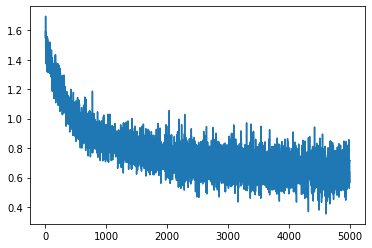

In [10]:
plt.plot(losses);

Plotamos as previsões do modelo:

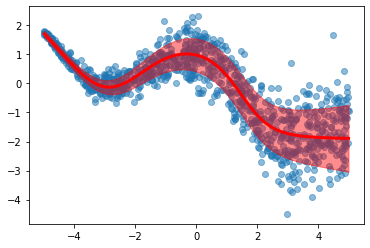

In [14]:
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5)

inputs = torch.from_numpy(x).float()
targets = torch.from_numpy(y).float()

inputs, targets = inputs.view(-1, 1), targets.view(-1, 1)

with torch.no_grad():
    outputs = model(inputs)
    yhat = outputs[0].numpy().flatten()
    sd = np.exp(outputs[1].numpy().flatten() / 2)

idx = np.argsort(x)
plt.plot(x[idx], yhat[idx], linewidth=3, color='red')
plt.fill_between(x[idx], yhat[idx] - sd[idx], yhat[idx] + sd[idx], color='red', alpha=0.45);

Como podemos observar, a faixa aumenta conforme nos movemos da esquerda para a direita e nosso modelo prevê com precisão que a variância deve aumentar conforme x aumenta.